In [1]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import sys
sys.path.append("./script")

#Data-Set and Model Loader

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from dataloader import CustomDataset

path_to_dataset = '/content/drive/MyDrive/'
dir_path_train = path_to_dataset + 'datasetTrain/'
dir_path_valid = path_to_dataset + 'datasetValid/'
train_ds = CustomDataset(dir_path_train)
valid_ds = CustomDataset(dir_path_valid)
len(train_ds), len(valid_ds)

(1867, 983)

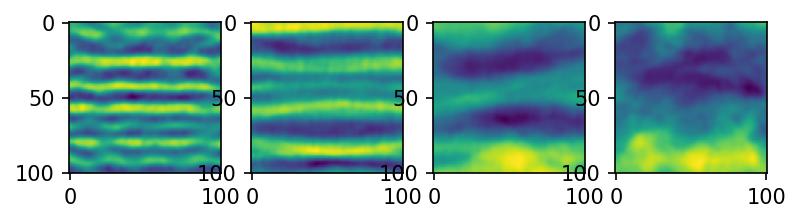

In [5]:
# plot images
x, y = valid_ds[100]
fig,ax = plt.subplots(1,4,figsize=(6,3),dpi=150)
for t in np.arange(4):
    ax[t].imshow(x[t])

plt.show()

In [6]:
training_dataloader = DataLoader(train_ds,batch_size=40,shuffle=True)
valid_dataloader = DataLoader(valid_ds,batch_size=40,shuffle=True)

In [7]:
# download data using csv reader is faster (then .. ) except in the first run,
# we start with the first run over the entiry data.
for x,y in tqdm(training_dataloader):
  pass
for x,y in tqdm(valid_dataloader):
  pass

100%|██████████| 25/25 [13:08<00:00, 31.52s/it]


In [8]:
from model_class import Classifier_Time
net_time = Classifier_Time()
print('num of parameters:', sum(len(p.view(-1)) for p in net_time.parameters()))
net_time.load_state_dict(torch.load('./trained_models/trained_model_class_time.pt',map_location='cpu'))

num of parameters: 421784


<All keys matched successfully>

In [9]:
from model_class import Classifier_Index
net_velocity = Classifier_Index()
print('num of parameters:', sum(len(p.view(-1)) for p in net_velocity.parameters()))
net_velocity.load_state_dict(torch.load('./trained_models/trained_model_class_velocity.pt',map_location='cpu'))

num of parameters: 422483


<All keys matched successfully>

In [10]:
from model_dimensional_reduction import VAE2
net_VAE2 = VAE2()
print('num of parameters:', sum(len(p.view(-1)) for p in net_VAE2.parameters()))
net_VAE2.load_state_dict(torch.load('./trained_models/trained_model_VAE2.pt',map_location='cpu'))

num of parameters: 1448213


<All keys matched successfully>

In [11]:
from model_dimensional_reduction import Z_Classifier
net_z = Z_Classifier()
print('num of parameters:', sum(len(p.view(-1)) for p in net_z.parameters()))
net_z.load_state_dict(torch.load('./trained_models/trained_model_z.pt',map_location='cpu'))


num of parameters: 5907


<All keys matched successfully>

In [12]:
# tr_param = torch.load('trained_model_AE0.pt',map_location='cpu')


In [13]:
# net_velocity.cpu()
# model = net_AE.state_dict()
# len(tr_param.items()), len(model.items())

In [14]:
# i=0
# for key, par in model.items():
#   i+=1
#   j=0
#   for key0, par0 in tr_param.items():
#     j+=1
#     if i==j:
#         model[key].copy_(par0)

# Comparing image-in to image-out

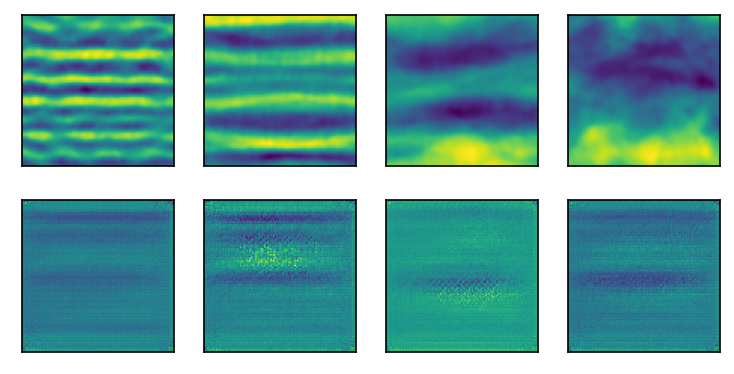

In [15]:
fig,ax = plt.subplots(2,4,figsize=(6,3),dpi=150)
net_VAE2.eval()
x, y = valid_ds[100]
x = x.unsqueeze(0)
with torch.no_grad():
  pred, _, _ = net_VAE2.cpu()(x)
  for t in range(4):
    x0 = x[:,t]
    pred0 = pred[:,t]  
    ax[0,t].imshow(x0[0].data.numpy())
    ax[1,t].imshow(pred0[0].data.numpy())
    ax[0,t].axes.xaxis.set_visible(False)
    ax[0,t].axes.yaxis.set_visible(False)
    ax[1,t].axes.xaxis.set_visible(False)
    ax[1,t].axes.yaxis.set_visible(False)
plt.show()

# Visualize the latent-space (using PCA)

For single images:

In [16]:
# training data-set

encodingT = {}
net_VAE2.eval().cpu()
for t in range(4):
  encodingT[t] = []

n_test = len(train_ds)

for test_i in tqdm( range(n_test) ):
    x,y = train_ds[test_i]
    for t in range(4):    
    
      enc_item = x[t].unsqueeze(0).unsqueeze(1)
      enc_item,_ = net_VAE2.enc(enc_item)
      encodingT[t].append( enc_item.cpu().data.numpy()[0] )
    
for key in encodingT:
    encodingT[key] = np.array(encodingT[key])

encoding_set = np.concatenate([encodingT[t] for t in range(4)])

# svd

U2, S2, VT2 = np.linalg.svd(encoding_set.T,full_matrices=0)

# validation data-set

encoding = {}
net_VAE2.eval().cpu()
for t in range(4):
  encoding[t] = []

n_test = len(valid_ds)

for test_i in tqdm( range(n_test) ):
    x,y = valid_ds[test_i]
    for t in range(4):    
    
      enc_item = x[t].unsqueeze(0).unsqueeze(1)
      enc_item,_ = net_VAE2.enc(enc_item)
      encoding[t].append( enc_item.cpu().data.numpy()[0] )
    
for key in encoding:
    encoding[key] = np.array(encoding[key])

100%|██████████| 983/983 [00:33<00:00, 29.47it/s]


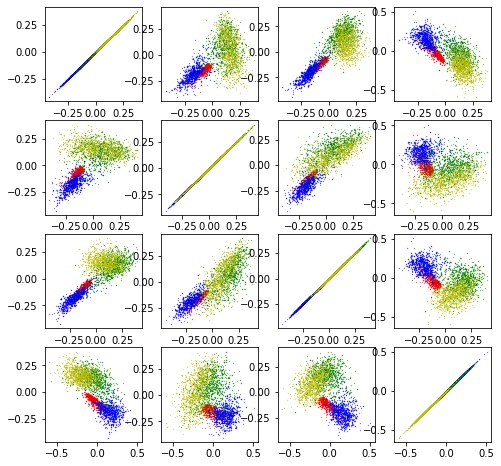

In [17]:
# visualize the latent space

color_list = ['r','b','g','y']

big = 4
fig,ax =plt.subplots(big,big,figsize=(8,8))

for dim1 in range(big):
  for dim2 in range(big):
    for key in range(4):
      ax[dim1,dim2].scatter(encoding[key][:,dim1],encoding[key][:,dim2],label=str(key),s=0.05,color=color_list[key])
        
plt.show()

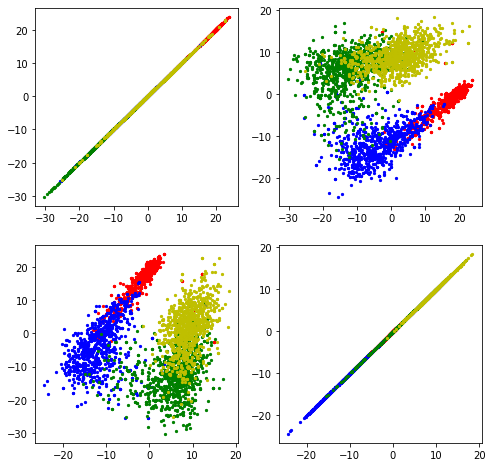

In [18]:
# visualize the latent space using PCA

S2R=np.diag(S2)
MatR = (U2@S2R)

color_list = ['r','b','g','y']
from matplotlib.patches import Ellipse
big = 2
fig,ax =plt.subplots(big,big,figsize=(8,8))

for dim1 in range(big):
  for dim2 in range(big):
    for key in range(4):
      ax[dim1,dim2].scatter((encoding[key]@MatR)[:,dim1],(encoding[key]@MatR)[:,dim2],label=str(key),s=5,color=color_list[key])
        
plt.show()

For sets of 4 images:

In [19]:
# For training-dataset

encoding3T = {}
net_VAE2.eval().cpu()
for v in range(3):
  encoding3T[v] = []

n_test = len(train_ds)

for test_i in tqdm( range(n_test) ):
    x,y = train_ds[test_i]
    enc_item = torch.cat([net_VAE2.enc(x[t].unsqueeze(0).unsqueeze(1))[0] for t in range(4)],1)
    encoding3T[y[0].item()].append( enc_item.data.numpy()[0] )
    
for key in encoding3T:
    encoding3T[key] = np.array(encoding3T[key])

encoding3_set = np.concatenate([encoding3T[v] for t in range(3)])

# svd

U3, S3, VT3 = np.linalg.svd(encoding3_set.T,full_matrices=0)


# For validation-dataset

encoding3 = {}
net_VAE2.eval().cpu()
for v in range(3):
  encoding3[v] = []

n_test = len(valid_ds)

for test_i in tqdm( range(n_test) ):
    x,y = valid_ds[test_i]
    enc_item = torch.cat([net_VAE2.enc(x[t].unsqueeze(0).unsqueeze(1))[0] for t in range(4)],1)
    encoding3[y[0].item()].append( enc_item.data.numpy()[0] )
    
for key in encoding3:
    encoding3[key] = np.array(encoding3[key])

100%|██████████| 983/983 [00:33<00:00, 29.30it/s]


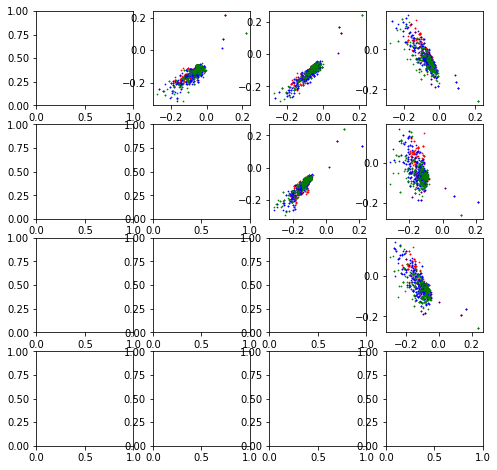

In [20]:
# visualize the latent space

color_list = ['r','b','g','y']

big = 4
fig,ax =plt.subplots(big,big,figsize=(8,8))

for dim1 in range(big):
  for dim2 in range(big):
    for key in range(3):
      if dim2>dim1:
        ax[dim1,dim2].scatter(encoding3[key][:,dim1],encoding3[key][:,dim2],label=str(key),s=0.5,color=color_list[key])
        
plt.show()

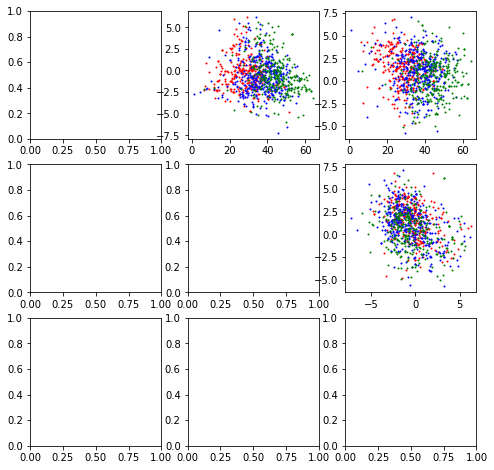

In [21]:
# visualize the latent space using PCA

S3R=np.diag(S3)
Mat3R = (U3@S3R)


color_list = ['r','b','g','y']
from matplotlib.patches import Ellipse
big = 3
fig,ax =plt.subplots(big,big,figsize=(8,8))

for dim1 in range(big):
  for dim2 in range(big):
    for key in range(3):
      if dim2>dim1:
        ax[dim1,dim2].scatter((encoding3[key]@Mat3R)[:,dim1],(encoding3[key]@Mat3R)[:,dim2],label=str(key),s=1,color=color_list[key])
        
plt.show()


# Creating fake images

In [26]:
pc1_mean = [np.mean(encoding3[v]@Mat3R,0)[0] for v in range(3)]
print(pc1_mean)
encode_mean = np.zeros((3,40))
for v in range(3):
  encode_mean[v,0] = pc1_mean[v]

[28.19516, 36.38499, 44.00494]


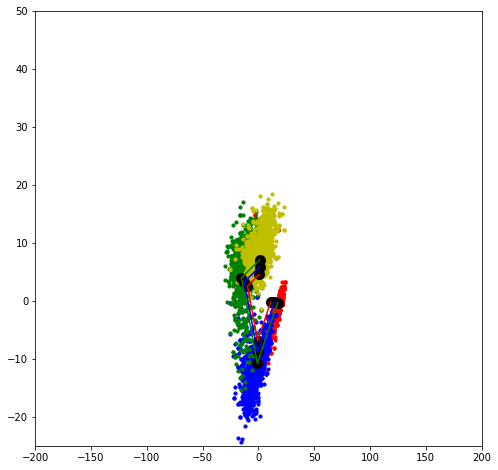

In [29]:
S3I=np.linalg.inv(np.diag(S3))
S3R=np.diag(S3)
Mat3R = (U3@S3R)
Mat3I = S3I@(U3.T)
Mat3 = Mat3R@Mat3I

latten_dim_mean = encode_mean@Mat3I
ld10_group = latten_dim_mean.reshape(3,4,10)

color_list = ['r','b','g','y']
from matplotlib.patches import Ellipse

fig,ax =plt.subplots(1,figsize=(8,8))

dim1 = 0
dim2 = 1
for key in encoding:
        ax.scatter((encoding[key]@MatR)[:,dim1],(encoding[key]@MatR)[:,dim2],label=str(key),s=10,color=color_list[key])
for v in range(3):
        ax.plot((ld10_group[v]@MatR)[:,dim1],(ld10_group[v]@MatR)[:,dim2],label=str(key),color=color_list[v])
        ax.scatter((ld10_group[v]@MatR)[:,dim1],(ld10_group[v]@MatR)[:,dim2],label=str(key),s=100,color='black')
plt.xlim(-200,200)
plt.ylim(-25,50)
plt.show()

In [31]:
# !pip install ipywidgets
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [35]:
S2I=np.linalg.inv(np.diag(S2))
S2R=np.diag(S2)
Mat2R = (U2@S2R)
Mat2I = S2I@(U2.T)
Mat2 = Mat2R@Mat2I


def find_ld10_pca(vel, time):
  ld40_pca = np.zeros(40)
  pc1_mean = [np.mean(encoding3[v]@Mat3R,0)[0] for v in range(3)]
  pc1_value = np.interp(vel,np.array([12,15,18]),np.array(pc1_mean))
  ld40_pca[0] = pc1_value
  ld40 = ld40_pca@Mat3I
  ld10 = ld40.reshape(4,10)
  ld10 = np.array([np.interp(time, np.arange(4), ld10[:,i]) for i in range(10)])
  ld10_pca = ld10@MatR
  return ld10_pca


def plot_ld10_pca(vel,time):
  color_list = ['r','b','g','y']
  fig,ax =plt.subplots(1,2,figsize=(8,4))
  dim1 = 0
  dim2 = 1
  ld10_pca = find_ld10_pca(vel,time)
  for key in encoding:
        ax[0].scatter((encoding[key]@MatR)[:,dim1],(encoding[key]@MatR)[:,dim2],label=str(key),s=5,color=color_list[key])
  for v in range(3):
        ax[0].plot((ld10_group[v]@MatR)[:,dim1],(ld10_group[v]@MatR)[:,dim2],label=str(key),color=color_list[v])
        ax[0].scatter(ld10_pca[0],ld10_pca[1],s=100,color='black')
  ax[0].set_xlim([-200,200])
  ax[0].set_ylim([-25,50])
  input_image = (ld10_pca@Mat2I).reshape(1,10)
  input_image = torch.FloatTensor(input_image)
  output_image = net_VAE2.dec(input_image)[0][0]
  output_image = output_image.data.numpy()
  ax[1].imshow(output_image)

  plt.show()



In [36]:
interact(plot_ld10_pca, vel=(12.,18.), time=(0.,4.));

interactive(children=(FloatSlider(value=15.0, description='vel', max=18.0, min=12.0), FloatSlider(value=2.0, d…